# Monte Carlo Radiative Transfer

## Background

### Important Variables

- Specific Intensity $I_v$ or $I(\mathbf{x}, t, \nu)$
- $\mathbf{x}$ position in space
- $t$ time
- $\nu$ frequency
- $\chi$ opacity

The radiative transfer equation describes the propagation of light through a medium. Let us start by assuming the light propagates through empty space then

$$
\frac{dI_v}{ds} = 0
$$

where $I$ is the intensity of light and $s$ is the distance traveled. Let us add a radiation absorbing medium to the mix. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v
$$

where $\alpha$ is the *fractioanl depletion coefficient* per path length. We can define the optical depth $\tau$ as

$$
d \tau_v = -\alpha_v ds
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = -I_v
$$

However radiation can also travel through a radiation emitting medium. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v + j_v
$$

where $j$ is the *emission coefficient*. We can also define it in terms of the optical depth

$$
\frac{dI_v}{d\tau_v} = \frac{j_v}{\alpha_v} - I_v.
$$

We then define the source function as 

$$
S_v = \frac{j_v}{\alpha_v}
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = S_v - I_v.
$$

## MCRT 

We can simulate the radiative transfer equation using Monte Carlo methods. We leverage an abstraction called photon packets, or machine photons, where a number of photons are grouped together. The photons are described by their position, direction, frequency, energy and weight. Over the course of the simulation, each photon packet continously accumulates optical depth. Hence contrary to classical simulations, we do not integrate over time but over optical depth.



We treat interactions with the medium as discrete interaction events, hence the MC algorithm needs to find when those events occur. We denote a random number as $\xi$. At the beginning of each packet trajectory event, each packet is assigned a new optical depth distance to the next interaction by

$$
\tau = -\log(\xi)
$$



In [1]:
using Plots

In [2]:
mutable struct PP
    # position in physical space
    pos::AbstractArray{Float64, 1}
    # propagation direction
    mu::AbstractArray{Float64, 1}
    # state of the packet, False means the photon has escaped
    absorbed::AbstractArray{Bool, 1}
    escaped::AbstractArray{Bool, 1}
end

In [3]:
function chi(r::Float64) :: Float64
    return 1 / (r + 1e-4)^2
end

# We can analytically integrate over chi, however we cannot really find the inverse of this function
# Therefore we stick to a grid based approach
function int_chi(r1::Float64, r2::Float64) :: Float64
    return -1 / (r2 + 1e-4) + 1 / (r1 + 1e-4)
end

int_chi (generic function with 1 method)

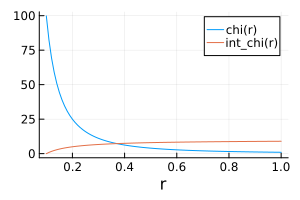

In [4]:
# plot chi
r = 0.1:0.01:1
# set plot size
plot(r, chi.(r), label="chi(r)", xlabel="r")
# plot the integral, use different y axis
plot!(r, int_chi.(0.1, r), label="int_chi(r)")
plot!(size=(300, 200))

In [18]:
struct Params
    # scattering coefficient
    chi_scattering::Float64
    # absorbtion coefficient
    chi_absorbtion::Float64
    # boundary of the domain
    boundary::Float64
    # enable scattering -> Drawing new directions
    enable_scattering::Bool
end

function event(p::PP, params::Params)::Nothing

    N = size(p.pos)[1]

    # sample optical depth to next event
    tau_to_next = -log.(rand(Float64, N))

    # We do not require a grid based approximation here as we have a smooth function available
    chi_total = 0.6

    # Invert the optical depth to get the phyiscal distance. 
    # Note that this is an approximation, as we cannot invert the integral over chi as there is no unique solution (?)
    l_to_next = tau_to_next ./ chi_total

    # Decide if packets crossed boundaries
    escaped = (p.pos .> params.boundary) .|| (p.pos .< -params.boundary)

    # Decide if packets are scattered or absorbed   
    is_absorbed = rand(N) .< (params.chi_absorbtion / (params.chi_absorbtion + params.chi_scattering))

    
    # Update the state of the packets
    p.pos .+= l_to_next .* p.mu
    if params.enable_scattering
        p.mu = rand(Float64, N) .* .2  .- 1
    end
    p.absorbed = !.pescaped .&& (p.absorbed .|| is_absorbed)
    p.escaped = p.escaped .|| escaped

    return nothing
    
end

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\andri\projects\computational-methods-for-radiative-transfer\mcrt.ipynb:38:19
    end
    p.absorbed = !.pescaped .&& (p.absorbed .|| is_absorbed)
#                 ╙ ── invalid identifier

In [23]:
function mcrt(
    N::Int64, 
    matter_density_profile::Function,
    params::Params,
    ) :: Float64


    println("Initalizing packets...")
    radius = 1.0
    # Initialize the packets
    pp = PP(
        radius .* rand(Float64, N) .^3,
        rand(Float64, N) .* 2 .- 1,
        zeros(Bool, N),
        zeros(Bool, N),
    )

    println("Starting simulation...")
    # Loop over the packets
    while any(.!(pp.absorbed .|| pp.escaped))
        println("Number of escaped packets: ", sum(pp.escaped) / N)
        println("Number of absorbed packets: ", sum(pp.absorbed) / N)
        event(pp, params)
    end

    return sum(pp.escaped) / N
end

mcrt (generic function with 1 method)

In [30]:
params = Params(
    0.6,
    0.4,
    0.1,
    true
)

esc_prob = mcrt(
    100000,
    x -> 1 / (x + 1e-6)^2,
    params
)



println("Escape probability: ", esc_prob)

Initalizing packets...
Starting simulation...
Number of escaped packets: 0.0
Number of absorbed packets: 0.0
Number of escaped packets: 0.53463
Number of absorbed packets: 0.40098
Number of escaped packets: 0.91107
Number of absorbed packets: 0.64275
Number of escaped packets: 0.99405
Number of absorbed packets: 0.78634
Number of escaped packets: 0.99982
Number of absorbed packets: 0.8717
Escape probability: 1.0
